# Import Object

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from models import AttentionRNN
from train_model import train_timeseries_net

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Subject of Comparison

In [3]:
class NonAttentionRNN(nn.Module):
    # pylint: disable=too-many-instance-attributes
    # Eleven seems reasonable in this case.
    def __init__(self, *, input_size, hidden_size, num_layers,
                 num_classes, dropout_ratio=0.5, is_bidirectional=True):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directional = 2 if is_bidirectional else 1
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, bidirectional=is_bidirectional)

        self.dropout1 = nn.Dropout(dropout_ratio)
        self.fc1 = nn.Linear(self.num_directional * hidden_size, 50)
        self.bn1 = nn.BatchNorm1d(50)

        self.dropout2 = nn.Dropout(dropout_ratio)
        self.fc2 = nn.Linear(50, 25)

        self.fc3 = nn.Linear(25, 10)
        self.fc4 = nn.Linear(10, num_classes)

    def forward(self, x, device):
        h0 = torch.zeros(self.num_directional * self.num_layers,
                         x.shape[0], self.hidden_size).to(device)
        c0 = torch.zeros(self.num_directional * self.num_layers,
                         x.shape[0], self.hidden_size).to(device)
        hs, _ = self.rnn(x, (h0,c0))
        out = self.dropout1(F.relu(self.fc1(hs)))
        out = out.reshape(x.shape[0], out.shape[2], x.shape[1])
        out = self.bn1(out)

        out = out.reshape(x.shape[0], x.shape[1], out.shape[1])
        out = self.dropout2(F.relu(self.fc2(out)))

        out = F.relu(self.fc3(out))
        out = self.fc4(out)
        return out

# Prepare Data

In [4]:
train_x = pd.read_csv("./data/X_simulate.csv").values
train_y = pd.read_csv("./data/Y_simulate.csv").values.reshape(-1)

sequence_length = 16
num_days = int(train_x.shape[0] / sequence_length)
feature_size = train_x.shape[1]
continuous_feature_size = 8
test_size = 0.1

train_x = train_x.reshape(num_days, sequence_length, feature_size)
train_y = train_y.reshape(num_days, sequence_length, 1)
train_x, test_x, train_y, test_y = train_test_split(train_x,
                                                    train_y,
                                                    test_size=test_size,
                                                    shuffle=True)

train_num_days = int(num_days * (1-test_size))
test_num_days = int(num_days - train_num_days)

train_x = train_x.reshape(train_num_days * sequence_length, feature_size)
test_x = test_x.reshape(test_num_days * sequence_length, feature_size)

ss = preprocessing.StandardScaler()
ss.fit(train_x[:, :continuous_feature_size])
train_x[:, :continuous_feature_size] = \
    ss.transform(train_x[:, :continuous_feature_size])

test_x[:, :continuous_feature_size] = \
    ss.transform(test_x[:, :continuous_feature_size])

train_x = train_x.reshape(train_num_days, sequence_length, feature_size)
test_x = test_x.reshape(test_num_days, sequence_length, feature_size)

train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

train_ds = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_ds, batch_size=6, shuffle=True)

# Set Free Parameters

In [5]:
input_size = 10
num_layers = 1
hidden_size = 100
num_classes = 1

learning_rate = 0.0005
weight_decay = 1e-3
eps = 1e-11
patience = 10

# Instantiate Model, Criterion, Optimizer

In [6]:
attention = AttentionRNN(input_size=input_size, hidden_size=hidden_size,
                         num_layers=num_layers, num_classes=num_classes).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(attention.parameters(), lr=learning_rate,
                       weight_decay=weight_decay, eps=eps)

In [7]:
non_attention = NonAttentionRNN(input_size=input_size, hidden_size=hidden_size,
                                num_layers=num_layers, num_classes=num_classes).to(device)
non_attention_optimizer = optim.Adam(non_attention.parameters(), lr=learning_rate,
                                     weight_decay=weight_decay, eps=eps)

# Training

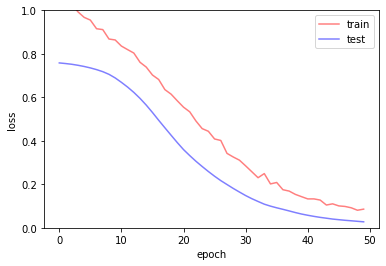

In [8]:
attention = train_timeseries_net(model=attention, criterion=criterion,
                                 optimizer=optimizer, train_loader=train_loader,
                                 test_x=test_x, test_y=test_y,
                                 device=device, patience=patience)

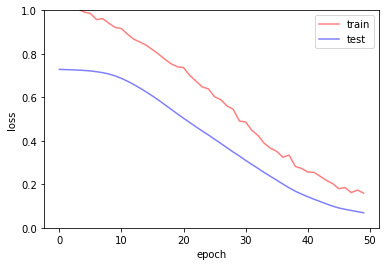

In [9]:
non_attention = train_timeseries_net(model=non_attention, criterion=criterion,
                                     optimizer=non_attention_optimizer, train_loader=train_loader,
                                     test_x=test_x, test_y=test_y,
                                     device=device, patience=patience)

# Accuracy

In [10]:
attention.eval()
score_y = attention(test_x, device).reshape(-1)
score_y = torch.sigmoid(score_y)
pred_y = torch.tensor([1 if i > 0.5 else 0 for i in score_y]).to(device)
test_y = test_y.reshape(-1)

print(sum(pred_y == test_y) / int(test_y.shape[0]))

tensor(1., device='cuda:0')


In [11]:
non_attention.eval()
score_y = non_attention(test_x, device).reshape(-1)
score_y = torch.sigmoid(score_y)
pred_y = torch.tensor([1 if i > 0.5 else 0 for i in score_y]).to(device)

print(sum(pred_y == test_y) / int(test_y.shape[0]))

tensor(1., device='cuda:0')
